In [1]:
import pandas as pd
import json
from json import encoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
# import data from cleaned json file
file = open('cleaned_input_file1.json')

In [3]:
# convert the input file to a dictionary
data_ls = json.load(file)
type(data_ls)

list

In [4]:
data_ls[0]

{'shop_name': 'Starbucks',
 'location': ['42.3399145', '-71.0887372'],
 'dish_name': 'Caffe Americano',
 'dish_description': 'Espresso shots topped with hot water create a light layer of crema culminating in this wonderfully rich cup with depth and nuance. Pro tip: For an additional boost, ask to try this with an extra shot.',
 'dish_image_link': 'https://media-cdn.grubhub.com/image/upload/w_1.46,h_1,c_lpad/tapingo-shops-assets/media/images/941/bcd/a4f817112069a2a985978813eeef447702',
 'dish_price': 3.45,
 'dish_category': 'Hot Coffees'}

In [5]:
# convert the dictionary to a panda dataframe
data_df = pd.DataFrame(data_ls)
data_clean = data_df.loc[data_df['dish_category'] != "The Saxby's Hall of Greats", :  ]
data_df = data_clean

In [6]:
dish_category_series = data_df.loc[:, ['shop_name', 'dish_category']]
dish_category_series_starbucks = dish_category_series.loc[dish_category_series['shop_name'] == 'Starbucks', :  ]
dish_category_series_saxbys = dish_category_series.loc[dish_category_series['shop_name'] == 'Saxby', :  ]
starbucks_dc = dish_category_series_starbucks.to_dict()
saxbys_dc = dish_category_series_saxbys.to_dict()

In [7]:
# check the different dish categories (combine both coffee shops's dish categories into one)
starbucks_categories_ls = []
saxbys_categories_ls = []

starbucks_dc.pop('shop_name', None)
saxbys_dc.pop('shop_name', None)

starbucks_unique_ls = []
saxby_unique_ls = []

for key in starbucks_dc['dish_category']:
    if starbucks_dc['dish_category'][key] not in starbucks_unique_ls:
        starbucks_unique_ls.append(starbucks_dc['dish_category'][key])

for key in saxbys_dc['dish_category']:
    if saxbys_dc['dish_category'][key] not in saxby_unique_ls:
        saxby_unique_ls.append(saxbys_dc['dish_category'][key])

# print the current dish categories for both places
print(f'Starbucks: {starbucks_unique_ls} \n')
print(f'Saxby: {saxby_unique_ls} \n')

Starbucks: ['Hot Coffees', 'Hot Teas', 'Hot Drinks', 'Frappuccino Blended Beverages', 'Cold Coffees', 'Cold Drinks', 'Iced Teas', 'Hot Breakfast', 'Oatmeal & Yogurt', 'Bakery', 'Lunch', 'Snacks & Sweets'] 

Saxby: ['Energy', 'Cold Brew Collection', 'Hot Coffee', 'Espresso Drinks', 'Teas & Steamers', 'Meet Your Matcha', 'Smoothies', 'Breakfast All Day', 'Grilled Cheese', 'Bakery', 'Grab & Go Food', 'Grab & Go Drinks', 'Coffee For Home'] 



In [8]:
# checking to see whether saxby's dish categories have some repeat dishes, isolate them to see what dishes they are.

dish_category_series_saxbys = data_df.loc[dish_category_series['shop_name'] == 'Saxby', : ]
dish_category_series_saxbys_clean = dish_category_series_saxbys.loc[ :, ['dish_category', 'dish_name']]
dict = dish_category_series_saxbys_clean.to_dict()

repeats_in_saxby_items = []
for key in dict['dish_name']:
    if dict['dish_name'][key] not in repeats_in_saxby_items:
        repeats_in_saxby_items.append({
            'dish_category': dict['dish_category'][key],
            'dish_name': dict['dish_name'][key],
        })

cleaned_repeats_saxby = {}

for index in repeats_in_saxby_items:
    if index['dish_name'] not in cleaned_repeats_saxby:
        cleaned_repeats_saxby[index['dish_name']] = [index['dish_category']]
    else:
        cleaned_repeats_saxby[index['dish_name']].append(index['dish_category'])

final_cleaned_saxby = {}

for key in cleaned_repeats_saxby:
    if len(cleaned_repeats_saxby[key]) != 1:
        final_cleaned_saxby[key] = cleaned_repeats_saxby[key]

for key, value in final_cleaned_saxby.items():
    print(f'{key}: {value}')
    print()

test_df = data_df.loc[data_df['dish_category'] == 'Energy' ,:]
shape_energy = test_df.shape
print(f'Energy {shape_energy}')

test_df = data_df.loc[data_df['dish_category'] == 'Meet Your Matcha' ,:]
shape_matcha = test_df.shape
print(f'Matcha {shape_matcha}')

test_df = data_df.loc[data_df['dish_category'] == 'Breakfast All Day' ,:]
shape_bkfast = test_df.shape
print(f'Breakfast {shape_bkfast}')

test_df = data_df.loc[data_df['dish_category'] == 'Grilled Cheese' ,:]
shape_gc = test_df.shape
print(f'Grilled Cheese {shape_gc}')

# Conclusion - 'Energy' and 'Meet Your Matcha' are redundant, can remove these categories.
# Breakfast Grilled Three Cheese - will remove as it is in both. 

Peach Rush Energy Drink: ['Energy', 'Teas & Steamers']

OG Rush Energy Drink: ['Energy', 'Teas & Steamers']

Strawberry Rush Energy Drink: ['Energy', 'Teas & Steamers']

Matcha Latte: ['Teas & Steamers', 'Meet Your Matcha']

Iced Matcha Latte: ['Teas & Steamers', 'Meet Your Matcha']

Breakfast Grilled Three Cheese: ['Breakfast All Day', 'Grilled Cheese']

Energy (3, 7)
Matcha (2, 7)
Breakfast (6, 7)
Grilled Cheese (7, 7)


In [9]:
# checking to see whether starbuck's dish categories have some repeat dishes, isolate them to see what dishes they are.

dish_category_series_starbucks = data_df.loc[dish_category_series['shop_name'] == 'Starbucks', : ]
dish_category_series_starbucks_clean = dish_category_series_starbucks.loc[ :, ['dish_category', 'dish_name']]
dict = dish_category_series_starbucks_clean.to_dict()

repeats_in_starbucks_items = []
for key in dict['dish_name']:
    if dict['dish_name'][key] not in repeats_in_starbucks_items:
        repeats_in_starbucks_items.append({
            'dish_category': dict['dish_category'][key],
            'dish_name': dict['dish_name'][key],
        })

cleaned_repeats_starbucks = {}

for index in repeats_in_starbucks_items:
    if index['dish_name'] not in cleaned_repeats_starbucks:
        cleaned_repeats_starbucks[index['dish_name']] = [index['dish_category']]
    else:
        cleaned_repeats_starbucks[index['dish_name']].append(index['dish_category'])

final_cleaned_starbucks = {}

for key in cleaned_repeats_starbucks:
    if len(cleaned_repeats_starbucks[key]) != 1:
        final_cleaned_starbucks[key] = cleaned_repeats_starbucks[key]

for key, value in final_cleaned_starbucks.items():
    print(f'{key}: {value}')
    print()

test_df = data_df.loc[data_df['dish_category'] == "Hot Breakfast" ,:]
shape_energy = test_df.shape
print(f'Hot Breakfast {shape_energy}')

test_df = data_df.loc[data_df['dish_category'] == 'Bakery' ,:]
shape_matcha = test_df.shape
print(f'Bakery {shape_matcha}')

test_df = data_df.loc[data_df['dish_category'] == 'Lunch' ,:]
shape_bkfast = test_df.shape
print(f'Lunch {shape_bkfast}')

test_df = data_df.loc[data_df['dish_category'] == 'Snacks & Sweets' ,:]
shape_gc = test_df.shape
print(f'Snacks & Sweets {shape_gc}')

# Conclusion - only one repeat item, Avacado Spread
# Avacado Spread - will remove as it is in all.

Avocado Spread: ['Hot Breakfast', 'Bakery', 'Lunch', 'Snacks & Sweets']

Hot Breakfast (12, 7)
Bakery (25, 7)
Lunch (9, 7)
Snacks & Sweets (5, 7)


In [10]:
#change DataFrame
#take care of Saxby's products
data_clean = data_df.loc[
    (data_df['dish_category'] != 'Energy') & 
    (data_df['dish_category'] != 'Meet Your Matcha') &
    (data_df['dish_name'] != 'Breakfast Grilled Three Cheese')]

data_df = data_clean

#take care of Starbuck's products
data_clean = data_df.loc[
    (data_df['dish_name'] != 'Avocado Spread')]

data_df = data_clean

Hot Coffees
Cold Coffees
Espresso Drinks
Teas & Herbal Beverages (This can encompass both hot teas and iced teas)
Frappuccino & Blended Beverages
Smoothies
Breakfast Items (Covering hot breakfast and breakfast all day)
Bakery Items (For all baked goods)
Snacks & Sweets
Lunch Items (This could include grab & go food)
Cold Drinks (For non-coffee cold beverages)
Coffee for Home (For packaged coffee products)

In [11]:
#combine both coffee shop's categories into one

Starbucks = ['Hot Coffees', 'Hot Teas', 'Hot Drinks', 'Frappuccino Blended Beverages', 
           'Cold Coffees', 'Cold Drinks', 'Iced Teas', 'Hot Breakfast', 'Oatmeal & Yogurt', 'Bakery', 'Lunch', 'Snacks & Sweets'] 

Saxby =  ['Cold Brew Collection', 'Hot Coffee', 'Espresso Drinks', 'Teas & Steamers', 
       'Smoothies', 'Breakfast All Day', 'Grilled Cheese', 'Bakery', 
       'Grab & Go Food', 'Grab & Go Drinks', 'Coffee For Home'] 

mapping_dict = {
    'Hot Coffees': 'Hot Coffees',
    'Hot Coffee': 'Hot Coffees',
    'Espresso Drinks': 'Hot Coffees',
    'Cold Coffees': 'Cold Coffees',
    'Cold Brew Collection': 'Cold Coffees',
    'Hot Drinks': 'Hot Drinks',
    'Cold Drinks': 'Cold Drinks',
    'Grab & Go Drinks': 'Cold Drinks', 
    'Teas & Steamers': 'Teas & Herbal Beverages',
    'Hot Teas': 'Teas & Herbal Beverages',
    'Iced Teas': 'Teas & Herbal Beverages',
    'Frappuccino Blended Beverages': 'Frappuccino & Blended Beverages',
    'Smoothies': 'Smoothies',
    'Breakfast All Day': 'Breakfast Items',
    'Hot Breakfast': 'Breakfast Items',
    'Bakery': 'Bakery Items',
    'Snacks & Sweets': 'Snacks & Sweets',
    'Oatmeal & Yogurt': 'Snacks & Sweets',
    'Lunch': 'Lunch Items',
    'Grab & Go Food': 'Lunch Items',
    'Grilled Cheese': 'Lunch Items',
    'Coffee For Home': 'Coffee for Home'
}

data_df['dish_category_unified'] = data_df['dish_category'].replace(mapping_dict)

data_df.head()
    

,shop_name,location,dish_name,dish_description,dish_image_link,dish_price,dish_category,dish_category_unified
0,Starbucks,"[42.3399145, -71.0887372]",Caffe Americano,Espresso shots topped with hot water create a ...,https://media-cdn.grubhub.com/image/upload/w_1...,3.45,Hot Coffees,Hot Coffees
1,Starbucks,"[42.3399145, -71.0887372]",Caffe Misto,A 1-to-1 combination of fresh-brewed coffee an...,https://media-cdn.grubhub.com/image/upload/w_1...,4.25,Hot Coffees,Hot Coffees
2,Starbucks,"[42.3399145, -71.0887372]",Blonde Roast Coffee,"Lightly roasted coffee that's soft, mellow and...",https://media-cdn.grubhub.com/image/upload/w_1...,3.45,Hot Coffees,Hot Coffees
3,Starbucks,"[42.3399145, -71.0887372]",Featured Starbucks Dark Roast Coffee,"This full-bodied dark roast coffee with bold, ...",https://media-cdn.grubhub.com/image/upload/w_1...,3.45,Hot Coffees,Hot Coffees
4,Starbucks,"[42.3399145, -71.0887372]",Pike Place Roast Coffee,From our first store in Seattle's Pike Place M...,https://media-cdn.grubhub.com/image/upload/w_1...,3.45,Hot Coffees,Hot Coffees


In [12]:
# check for null values in the dataframe
# note - there were null prices, but were removed from json file inadvently (was fixing format of prices).
print(data_df.isnull().sum())

shop_name                0
location                 0
dish_name                0
dish_description         0
dish_image_link          0
dish_price               0
dish_category            0
dish_category_unified    0
dtype: int64


In [13]:
# consequence of the messup :(
df_clean = data_df

In [14]:
# Convert dish_category_unified to numerical values using LabelEncoder
# For K mean clustering, need numerical representation of catagorical data, hence adding this. 
le = LabelEncoder()
df_clean.loc[:, 'dish_category_unified_encoded'] = le.fit_transform(df_clean['dish_category_unified'])

In [15]:
# Normalizing (shrinking the range) of prices to allow for better k mean clustering.
scaler = StandardScaler()
df_clean['price_normalized'] = scaler.fit_transform(df_clean[['dish_price']])

In [16]:
df_clean.head()

,shop_name,location,dish_name,dish_description,dish_image_link,dish_price,dish_category,dish_category_unified,dish_category_unified_encoded,price_normalized
0,Starbucks,"[42.3399145, -71.0887372]",Caffe Americano,Espresso shots topped with hot water create a ...,https://media-cdn.grubhub.com/image/upload/w_1...,3.45,Hot Coffees,Hot Coffees,6,-0.499990
1,Starbucks,"[42.3399145, -71.0887372]",Caffe Misto,A 1-to-1 combination of fresh-brewed coffee an...,https://media-cdn.grubhub.com/image/upload/w_1...,4.25,Hot Coffees,Hot Coffees,6,-0.027383
2,Starbucks,"[42.3399145, -71.0887372]",Blonde Roast Coffee,"Lightly roasted coffee that's soft, mellow and...",https://media-cdn.grubhub.com/image/upload/w_1...,3.45,Hot Coffees,Hot Coffees,6,-0.499990
3,Starbucks,"[42.3399145, -71.0887372]",Featured Starbucks Dark Roast Coffee,"This full-bodied dark roast coffee with bold, ...",https://media-cdn.grubhub.com/image/upload/w_1...,3.45,Hot Coffees,Hot Coffees,6,-0.499990
4,Starbucks,"[42.3399145, -71.0887372]",Pike Place Roast Coffee,From our first store in Seattle's Pike Place M...,https://media-cdn.grubhub.com/image/upload/w_1...,3.45,Hot Coffees,Hot Coffees,6,-0.499990


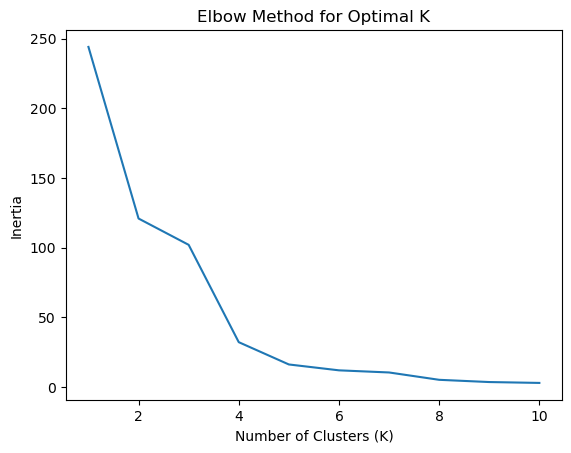

In [24]:
# apply k-means clustering (use dish_price to create clusters)
# create a list to store all intertia
# an inertia is the sum of squared distances from each point to its clustoid (the nearest cluster)
inertia = []
# check for best fit between 1 and 8 clusters.
for k in range(1, 11):
    # creates the KMeans object for k clusters.
    kmeans = KMeans(n_clusters=k, random_state=42)
    # fit the KMeans object to the priced_normalized column.
    kmeans.fit(df_clean[['price_normalized']])
    # add resulting inertia to the list.
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.plot(range(1, 11), inertia)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

In [25]:
# above graph shows the greatest change ('elblow') at 4, so we will use 4 clusters
optimal_k = 4 
# run the KMeans algorithm for 3 clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_clean['cluster'] = kmeans.fit_predict(df_clean[['price_normalized']])

In [26]:
df_clean.head()

,shop_name,location,dish_name,dish_description,dish_image_link,dish_price,dish_category,dish_category_unified,dish_category_unified_encoded,price_normalized,cluster
0,Starbucks,"[42.3399145, -71.0887372]",Caffe Americano,Espresso shots topped with hot water create a ...,https://media-cdn.grubhub.com/image/upload/w_1...,3.45,Hot Coffees,Hot Coffees,6,-0.499990,2
1,Starbucks,"[42.3399145, -71.0887372]",Caffe Misto,A 1-to-1 combination of fresh-brewed coffee an...,https://media-cdn.grubhub.com/image/upload/w_1...,4.25,Hot Coffees,Hot Coffees,6,-0.027383,2
2,Starbucks,"[42.3399145, -71.0887372]",Blonde Roast Coffee,"Lightly roasted coffee that's soft, mellow and...",https://media-cdn.grubhub.com/image/upload/w_1...,3.45,Hot Coffees,Hot Coffees,6,-0.499990,2
3,Starbucks,"[42.3399145, -71.0887372]",Featured Starbucks Dark Roast Coffee,"This full-bodied dark roast coffee with bold, ...",https://media-cdn.grubhub.com/image/upload/w_1...,3.45,Hot Coffees,Hot Coffees,6,-0.499990,2
4,Starbucks,"[42.3399145, -71.0887372]",Pike Place Roast Coffee,From our first store in Seattle's Pike Place M...,https://media-cdn.grubhub.com/image/upload/w_1...,3.45,Hot Coffees,Hot Coffees,6,-0.499990,2


In [27]:
numeric_columns = ['dish_price', 'dish_category_unified_encoded', 'price_normalized']
cluster_summary = df_clean.groupby(['cluster', 'shop_name'])[numeric_columns].mean()
print(cluster_summary)

                   dish_price  dish_category_unified_encoded  price_normalized
cluster shop_name                                                             
0       Saxby        5.712000                       6.466667          0.836307
        Starbucks    5.237342                       4.962025          0.555898
1       Saxby        2.200000                       6.629630         -1.238439
        Starbucks    2.681818                       5.000000         -0.953801
2       Saxby        3.795455                       6.318182         -0.295910
        Starbucks    3.816000                       5.300000         -0.283773
3       Saxby       13.666667                       2.000000          5.535599


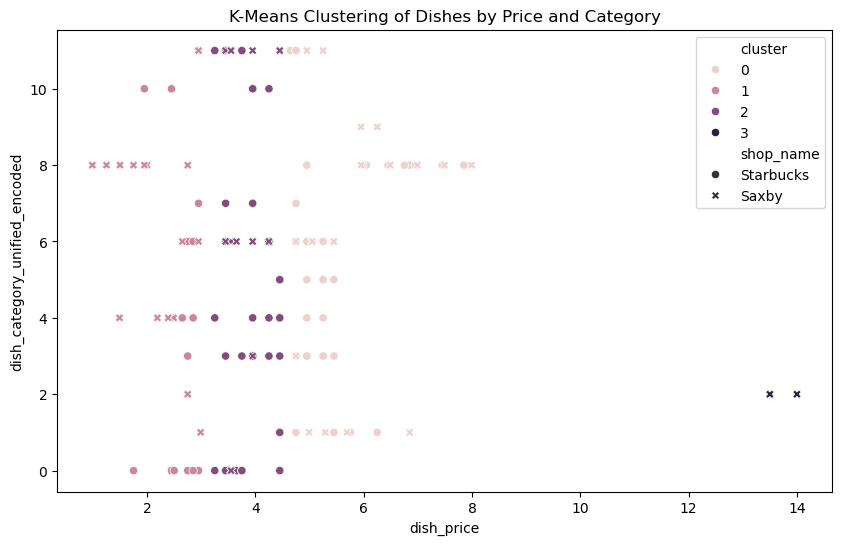

In [28]:
import seaborn as sns

# Scatter plot showing clusters by price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='dish_price', y='dish_category_unified_encoded', hue='cluster', style='shop_name')
plt.title('K-Means Clustering of Dishes by Price and Category')
plt.show()

cluster  shop_name
0        Saxby         5.712000
         Starbucks     5.237342
1        Saxby         2.200000
         Starbucks     2.681818
2        Saxby         3.795455
         Starbucks     3.816000
3        Saxby        13.666667
Name: dish_price, dtype: float64